In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install optuna lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 37.8 MB/s eta 0:00:00


In [ ]:
# ==============
# 1. IMPORTS
# ==============
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.nn import MSELoss
from lightning.pytorch import LightningModule
import pandas as pd
from sklearn.model_selection import KFold
import torch.optim as optim
import os
import functools
import torch.nn as nn
import time

# ========================
# 2. MODEL DEFINITION
# ========================
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5, learning_rate=0.001):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.learning_rate = learning_rate
        self.loss_fn = MSELoss()

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        # --- FIX #1: This was causing a shape error. It now correctly keeps the 3D shape for the attention mechanism. ---
        input_tensor_after_cnn = cnn_hidden

        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer = mixed_query_layer
        key_layer = mixed_key_layer
        value_layer = mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

    # (The rest of the class methods are fine)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        val_loss = self.loss_fn(y_pred, y)
        return val_loss
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.learning_rate)

# ========================
# 3. HELPER FUNCTIONS
# ========================
def objective(trial, x_train, y_train, inner_cv, DEVICE, hidden_dim, output_dim, kernel_size, learning_rate):
    # This function is for hyperparameter tuning and seems okay.
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [4, 8])
    attention_probs_dropout_prob = trial.suggest_categorical('attention_probs_dropout_prob', [0.2, 0.5])
    fold_losses = []
    for train_idx, valid_idx in inner_cv.split(x_train):
        x_inner_train, x_inner_valid = x_train[train_idx], x_train[valid_idx]
        y_inner_train, y_inner_valid = y_train[train_idx], y_train[valid_idx]
        scaler = StandardScaler()
        x_inner_train = scaler.fit_transform(x_inner_train)
        x_inner_valid = scaler.transform(x_inner_valid)
        x_inner_train_tensor = torch.from_numpy(x_inner_train).float().to(DEVICE)
        y_inner_train_tensor = torch.from_numpy(y_inner_train).float().to(DEVICE)
        x_inner_valid_tensor = torch.from_numpy(x_inner_valid).float().to(DEVICE)
        y_inner_valid_tensor = torch.from_numpy(y_inner_valid).float().to(DEVICE)
        train_data = TensorDataset(x_inner_train_tensor, y_inner_train_tensor)
        valid_data = TensorDataset(x_inner_valid_tensor, y_inner_valid_tensor)
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
        model = SelfAttention(num_attention_heads, x_inner_train.shape[1], hidden_dim, output_dim,
                              hidden_dropout_prob=0.5, kernel_size=kernel_size,
                              attention_probs_dropout_prob=attention_probs_dropout_prob).to(DEVICE)
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(20):
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = loss_function(y_pred, y_batch.reshape(-1, 1))
                loss.backward()
                optimizer.step()
        model.eval()
        valid_losses = []
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                y_pred = model(x_batch)
                loss = loss_function(y_pred, y_batch.reshape(-1, 1))
                valid_losses.append(loss.item())
        fold_losses.append(np.mean(valid_losses))
    return np.mean(fold_losses)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = -np.Inf
        self.counter = 0
        self.early_stop = False
    def __call__(self, score):
        if self.best_score == -np.Inf:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def run_nested_cv_with_early_stopping(data, label, outer_cv, inner_cv, learning_rate, batch_size, hidden_dim,
                                      output_dim, kernel_size, patience, DEVICE):
    best_corr_coefs = []
    time_star = time.time()
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(data)):
        model_save_path = f'/content/drive/MyDrive/crop_former_model/best_model_fold_{fold + 1}.pth'
        if os.path.exists(model_save_path):
            print(f"✅ Fold {fold + 1} already completed. Model file found. Skipping.")
            continue
        print(f"\n--- Starting Fold {fold + 1}/5 ---")
        x_train, x_test = data[train_idx], data[test_idx]
        y_train, y_test = label[train_idx], label[test_idx]
        print("Running Optuna for hyperparameter tuning...")
        objective_with_data = functools.partial(objective, x_train=x_train, y_train=y_train, inner_cv=inner_cv,
                                                DEVICE=DEVICE, hidden_dim=hidden_dim, output_dim=output_dim,
                                                kernel_size=kernel_size, learning_rate=learning_rate)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_with_data, n_trials=20)
        best_trial = study.best_trial
        print(f"Optuna found best params for Fold {fold + 1}: {best_trial.params}")
        num_attention_heads = best_trial.params['num_attention_heads']
        attention_probs_dropout_prob = best_trial.params['attention_probs_dropout_prob']
        model = SelfAttention(num_attention_heads, x_train.shape[1], hidden_dim, output_dim,
                              hidden_dropout_prob=0.5, kernel_size=kernel_size,
                              attention_probs_dropout_prob=attention_probs_dropout_prob).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_function = torch.nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # --- FIX #2: This was the source of the NameError. It now correctly uses x_train, y_train, etc. ---
        x_train_tensor = torch.from_numpy(x_train).float().to(DEVICE)
        y_train_tensor = torch.from_numpy(y_train).float().to(DEVICE)
        x_test_tensor = torch.from_numpy(x_test).float().to(DEVICE)
        y_test_tensor = torch.from_numpy(y_test).float().to(DEVICE)

        train_data = TensorDataset(x_train_tensor, y_train_tensor)
        test_data = TensorDataset(x_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_data, batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size, shuffle=False)
        early_stopping = EarlyStopping(patience=patience)
        best_corr_coef = -float('inf')
        print(f"Starting final training for Fold {fold + 1}...")
        for epoch in range(100):
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = loss_function(y_pred, y_batch.reshape(-1, 1))
                loss.backward()
                optimizer.step()
            model.eval()
            y_test_preds, y_test_trues = [], []
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    y_test_pred = model(x_batch)
                    y_test_preds.extend(y_test_pred.cpu().numpy().reshape(-1).tolist())
                    y_test_trues.extend(y_batch.cpu().numpy().reshape(-1).tolist())
            corr_coef = np.corrcoef(y_test_preds, y_test_trues)[0, 1]
            scheduler.step(corr_coef)
            if corr_coef > best_corr_coef:
                best_corr_coef = corr_coef
                torch.save(model.state_dict(), model_save_path)
            early_stopping(corr_coef)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        best_corr_coefs.append(best_corr_coef)
        print(f'Fold {fold + 1}: Best Correlation Coefficient: {best_corr_coef:.4f}')
    average_corr_coef = np.mean(best_corr_coefs)
    print(f"\n--- Training Complete ---")
    print(f"Average Best Correlation Coefficient across all folds: {average_corr_coef:.4f}")
    time_end = time.time()
    execution_time = int(time_end - time_star)
    print(f"Total execution time: {execution_time // 60} minutes, {execution_time % 60} seconds.")
    result_data = {'time': [execution_time], 'mean_corr_coef': [average_corr_coef]}
    pd.DataFrame(result_data).to_csv("/content/drive/MyDrive/crop_former_model/final_training_results.csv")

def data_preprocessing(data_path, label_path, target_columns=10000):
    label = pd.read_csv(label_path, index_col=0).values
    data = pd.read_csv(data_path, index_col=0)
    if data.shape[1] < target_columns:
        missing_columns = target_columns - data.shape[1]
        zeros_df = pd.DataFrame(np.zeros((data.shape[0], missing_columns)))
        data = pd.concat([data, zeros_df], axis=1)
    data = data.values
    return data, label

# ============================
# 4. MAIN EXECUTION BLOCK
# ============================
if __name__ == '__main__':
    # --- Hyperparameters ---
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    batch_size = 128
    learning_rate = 0.001
    patience = 5
    hidden_dim = 64
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {DEVICE}")

    # --- File Paths ---
    data_path = "/content/drive/MyDrive/crop_former_model/X_train.csv"
    label_path = "/content/drive/MyDrive/crop_former_model/y_train.csv"

    # --- Run ---
    print("Starting data preprocessing...")
    data, label = data_preprocessing(data_path, label_path)
    print("Data preprocessing complete. Starting training...")
    run_nested_cv_with_early_stopping(data=data, label=label, outer_cv=outer_cv,
                                      inner_cv=inner_cv, learning_rate=learning_rate,
                                      batch_size=batch_size, hidden_dim=hidden_dim, output_dim=1,
                                      kernel_size=3, patience=patience, DEVICE=DEVICE)
    print("--- Successfully Finished ---")

Training on device: cuda
Starting data preprocessing...
Data preprocessing complete. Starting training...

--- Starting Fold 1/5 ---


[I 2025-10-04 07:38:26,208] A new study created in memory with name: no-name-9bbdd24d-4d63-4136-805d-45ce73b5e9c7


Running Optuna for hyperparameter tuning...


[I 2025-10-04 07:38:44,091] Trial 0 finished with value: 353.6909993489583 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 353.6909993489583.
[I 2025-10-04 07:39:01,157] Trial 1 finished with value: 604.6578494340946 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 353.6909993489583.
[I 2025-10-04 07:39:19,048] Trial 2 finished with value: 517.586169642261 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 353.6909993489583.
[I 2025-10-04 07:39:36,890] Trial 3 finished with value: 398.65988863431494 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 353.6909993489583.
[I 2025-10-04 07:39:54,053] Trial 4 finished with value: 450.1202152610844 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 353.

Optuna found best params for Fold 1: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 1...
Early stopping at epoch 20
Fold 1: Best Correlation Coefficient: 0.8090

--- Starting Fold 2/5 ---


[I 2025-10-04 07:44:26,039] A new study created in memory with name: no-name-e2b84bde-6e06-4b20-80a5-b8cd41d1a4c7


Running Optuna for hyperparameter tuning...


[I 2025-10-04 07:44:44,116] Trial 0 finished with value: 489.9615627191006 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 489.9615627191006.
[I 2025-10-04 07:45:01,650] Trial 1 finished with value: 479.45655601045 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 1 with value: 479.45655601045.
[I 2025-10-04 07:45:21,275] Trial 2 finished with value: 413.1463390904614 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 2 with value: 413.1463390904614.
[I 2025-10-04 07:45:38,994] Trial 3 finished with value: 487.7657953246027 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 413.1463390904614.
[I 2025-10-04 07:45:56,629] Trial 4 finished with value: 390.6503024631076 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 4 with value: 390.6503

Optuna found best params for Fold 2: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 2...
Early stopping at epoch 75
Fold 2: Best Correlation Coefficient: 0.9417

--- Starting Fold 3/5 ---


[I 2025-10-04 07:50:46,500] A new study created in memory with name: no-name-e1a12e1c-02b5-4702-b363-d25449a4a4be


Running Optuna for hyperparameter tuning...


[I 2025-10-04 07:51:03,959] Trial 0 finished with value: 597.2101962097689 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 597.2101962097689.
[I 2025-10-04 07:51:22,896] Trial 1 finished with value: 504.1681951539129 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 1 with value: 504.1681951539129.
[I 2025-10-04 07:51:41,093] Trial 2 finished with value: 486.88317818926953 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 486.88317818926953.
[I 2025-10-04 07:52:01,675] Trial 3 finished with value: 497.7334722535223 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 486.88317818926953.
[I 2025-10-04 07:52:20,822] Trial 4 finished with value: 504.28173932458594 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 

Optuna found best params for Fold 3: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 3...
Early stopping at epoch 49
Fold 3: Best Correlation Coefficient: 0.9363

--- Starting Fold 4/5 ---


[I 2025-10-04 07:57:28,489] A new study created in memory with name: no-name-3e5eb089-75c1-492c-aaf8-1afa13457088


Running Optuna for hyperparameter tuning...


[I 2025-10-04 07:57:46,861] Trial 0 finished with value: 477.2264190412994 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 477.2264190412994.
[I 2025-10-04 07:58:04,437] Trial 1 finished with value: 586.4726421649639 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 477.2264190412994.
[I 2025-10-04 07:58:22,779] Trial 2 finished with value: 477.21240495209 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 477.21240495209.
[I 2025-10-04 07:58:40,104] Trial 3 finished with value: 498.09606868385254 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 477.21240495209.
[I 2025-10-04 07:58:57,394] Trial 4 finished with value: 502.6407564603366 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 2 with value: 477.21240

Optuna found best params for Fold 4: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 4...
Early stopping at epoch 47
Fold 4: Best Correlation Coefficient: 0.9427

--- Starting Fold 5/5 ---


[I 2025-10-04 08:03:39,560] A new study created in memory with name: no-name-fbc54b1c-ec33-4f8a-9688-69c382ca5d18


Running Optuna for hyperparameter tuning...


[I 2025-10-04 08:03:57,250] Trial 0 finished with value: 415.24580292008886 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 415.24580292008886.
[I 2025-10-04 08:04:14,436] Trial 1 finished with value: 519.2561893300114 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 415.24580292008886.
[I 2025-10-04 08:04:32,216] Trial 2 finished with value: 577.575193225828 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 415.24580292008886.
[I 2025-10-04 08:04:49,559] Trial 3 finished with value: 379.4198857494909 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 3 with value: 379.4198857494909.
[I 2025-10-04 08:05:06,679] Trial 4 finished with value: 332.700180314545 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 4 with value: 33

Optuna found best params for Fold 5: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 5...
Early stopping at epoch 29
Fold 5: Best Correlation Coefficient: 0.9277

--- Training Complete ---
Average Best Correlation Coefficient across all folds: 0.9115
Total execution time: 31 minutes, 7 seconds.
--- Successfully Finished ---


In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from lightning.pytorch import LightningModule

# (The model definition is copied here for the script to be self-contained)
class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5, learning_rate=0.001):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer, key_layer, value_layer = mixed_query_layer, mixed_key_layer, mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# --- Main Prediction Logic ---
if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {DEVICE}')

    # --- UPDATE THESE FILE PATHS ---
    # Use the model from the fold with the highest score (e.g., Fold 5)
    model_path = '/content/drive/MyDrive/crop_former_model/best_model_fold_5.pth'

    # We need the training data to fit the scaler correctly
    train_data_path = '/content/drive/MyDrive/crop_former_model/X_train.csv'

    # This is the "new" data we want to predict on
    test_data_path = '/content/drive/MyDrive/crop_former_model/X_test.csv'

    # This is where the final predictions will be saved
    output_path = '/content/drive/MyDrive/crop_former_model/predicted_result.csv'
    # --------------------------------

    # --- Hyperparameters (must match the trained model) ---
    input_size = 10000
    # Use the best params found for your best fold.
    # From your log, Fold 5 used: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}
    num_attention_heads = 4
    attention_probs_dropout_prob = 0.5

    # Initialize the model structure
    model = SelfAttention(num_attention_heads=num_attention_heads, input_size=input_size,
                          hidden_size=64, output_dim=1, kernel_size=3,
                          attention_probs_dropout_prob=attention_probs_dropout_prob).to(DEVICE)

    # Load the saved weights
    print(f"Loading trained model from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))

    # --- CRITICAL FIX: SCALING THE DATA ---
    print("Loading training data to fit the scaler...")
    X_train = pd.read_csv(train_data_path, index_col=0)

    scaler = StandardScaler()
    scaler.fit(X_train.values) # Fit the scaler ONLY on the training data

    print(f"Loading and scaling test data from: {test_data_path}")
    X_test = pd.read_csv(test_data_path, index_col=0)
    X_test_scaled = scaler.transform(X_test.values) # Transform the test data
    # -----------------------------------------

    X_test_tensor = torch.from_numpy(X_test_scaled).to(torch.float32).to(DEVICE)

    # Make predictions
    print("Making predictions on the test data...")
    model.eval()
    with torch.no_grad():
        output = model(X_test_tensor)

    # Save predictions
    pd.DataFrame(output.cpu().numpy(), columns=['predicted_value'], index=X_test.index).to_csv(output_path)

    print(f"✅ Success! Predictions saved to '{output_path}'.")

Using device: cuda
Loading trained model from: /content/drive/MyDrive/crop_former_model/best_model_fold_5.pth
Loading training data to fit the scaler...
Loading and scaling test data from: /content/drive/MyDrive/crop_former_model/X_test.csv
Making predictions on the test data...
✅ Success! Predictions saved to '/content/drive/MyDrive/crop_former_model/predicted_result.csv'.


In [ ]:
import pandas as pd
import numpy as np

# --- IMPORTANT: UPDATE THESE FILE PATHS ---
# Path to the file with your model's predictions
predicted_file = '/content/drive/MyDrive/crop_former_model/predicted_result.csv'

# Path to the file with the true, original test labels
true_labels_file = '/content/drive/MyDrive/crop_former_model/y_test.csv'
# -----------------------------------------

# Load the datasets
predicted_df = pd.read_csv(predicted_file)
true_df = pd.read_csv(true_labels_file)

# Extract the numerical values
predicted_values = predicted_df['predicted_value'].values
true_values = true_df.iloc[:, 1].values # Select the second column which contains the phenotype values

# Calculate the Pearson Correlation Coefficient (PCC)
# np.corrcoef returns a 2x2 matrix, the value at [0, 1] is the correlation
accuracy = np.corrcoef(predicted_values, true_values)[0, 1]

print(f"✅ Model Accuracy (Pearson Correlation Coefficient): {accuracy:.4f}")

✅ Model Accuracy (Pearson Correlation Coefficient): 0.9285


In [ ]:
import pandas as pd
import numpy as np

# --- Configuration ---
# File with the correct 10,000 SNP columns
feature_file = '/content/drive/MyDrive/crop_former_model/chr10_top10k_snps.csv'

# Name of our new simulated data file
output_simulated_file = '/content/drive/MyDrive/crop_former_model/new_simulated_maize.csv'

# How many new samples to simulate
num_new_samples = 5
# ---------------------

print("Creating a simulated data file for prediction...")

# Read just the header of the feature file to get the column names
try:
    snp_columns = pd.read_csv(feature_file, nrows=0).columns[1:] # Skip the first 'IID' column

    # Create some new, fake sample IDs
    new_sample_ids = [f'Maize_Sample_{i+1}' for i in range(num_new_samples)]

    # Create a DataFrame with the correct shape
    simulated_df = pd.DataFrame(index=new_sample_ids, columns=snp_columns)
    simulated_df.index.name = 'IID'

    # Fill it with random genotype data (the 0-9 encoding)
    # This simulates having new genotype data for the same SNPs
    simulated_data = np.random.randint(0, 10, size=simulated_df.shape)
    simulated_df[:] = simulated_data

    # Save the simulated data to a new CSV file
    simulated_df.to_csv(output_simulated_file)

    print(f"✅ Success! Created '{output_simulated_file}' with {num_new_samples} simulated samples.")

except FileNotFoundError:
    print(f"❌ Error: Make sure '{feature_file}' exists in your Google Drive.")

Creating a simulated data file for prediction...
✅ Success! Created '/content/drive/MyDrive/crop_former_model/new_simulated_maize.csv' with 5 simulated samples.


In [ ]:
t

In [ ]:
# ===================================================================
# Master Prediction and Evaluation Script for Cropformer
# ===================================================================
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from lightning.pytorch import LightningModule
import os

# ========================
# 1. MODEL DEFINITION
# (This must be included so the script knows the model's structure)
# ========================
class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer, key_layer, value_layer = mixed_query_layer, mixed_key_layer, mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# ========================
# 2. CONFIGURATION
# (Update these paths to match your Google Drive)
# ========================
DRIVE_FOLDER = '/content/drive/MyDrive/crop_former_model/'
MODEL_FOLDER = DRIVE_FOLDER

# Input files
TRAIN_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_train.csv')
TEST_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_test.csv')
TEST_LABELS_PATH = os.path.join(DRIVE_FOLDER, 'y_test.csv')
NEW_DATA_PATH = os.path.join(DRIVE_FOLDER, 'new_simulated_maize.csv')

# --- Hyperparameters (must match the models you trained) ---
INPUT_SIZE = 10000
HIDDEN_SIZE = 64

# ========================
# 3. MAIN SCRIPT LOGIC
# ========================
if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {DEVICE}\n')

    # --- Part 1: Evaluate the accuracy of each saved model ---
    print("--- Evaluating Accuracy of Saved Models ---")

    # Load data for evaluation
    X_train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
    X_test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)
    y_test_df = pd.read_csv(TEST_LABELS_PATH, index_col=0)

    # Fit a scaler on the training data
    scaler = StandardScaler()
    scaler.fit(X_train_df.values)

    # Scale the test data
    X_test_scaled = scaler.transform(X_test_df.values)
    X_test_tensor = torch.from_numpy(X_test_scaled).to(torch.float32).to(DEVICE)
    true_values = y_test_df.values.flatten()

    model_accuracies = {}

    for i in range(1, 6):
        model_name = f'best_model_fold_{i}.pth'
        model_path = os.path.join(MODEL_FOLDER, model_name)

        # NOTE: This assumes best params are similar across folds. For highest accuracy,
        # you'd need to load the specific params for each fold. We use the best overall.
        best_params = {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}

        model = SelfAttention(**best_params, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        with torch.no_grad():
            predictions_tensor = model(X_test_tensor)

        predicted_values = predictions_tensor.cpu().numpy().flatten()

        # Calculate Pearson Correlation
        accuracy = np.corrcoef(predicted_values, true_values)[0, 1]
        model_accuracies[model_name] = accuracy
        print(f"  - {model_name}: Accuracy = {accuracy:.4f}")

    print(f"\nAverage Accuracy: {np.mean(list(model_accuracies.values())):.4f}\n")

    # --- Part 2: Predict DTT for new data ---
    print(f"--- Predicting DTT for New Data from '{os.path.basename(NEW_DATA_PATH)}' ---")

    # Load the new data
    new_data_df = pd.read_csv(NEW_DATA_PATH, index_col=0)

    # Scale the new data using the SAME scaler fitted on the training data
    new_data_scaled = scaler.transform(new_data_df.values)
    new_data_tensor = torch.from_numpy(new_data_scaled).to(torch.float32).to(DEVICE)

    all_predictions = {}

    for i in range(1, 6):
        model_name = f'best_model_fold_{i}.pth'
        model_path = os.path.join(MODEL_FOLDER, model_name)

        best_params = {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}

        model = SelfAttention(**best_params, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        with torch.no_grad():
            predictions_tensor = model(new_data_tensor)

        all_predictions[f'Model_Fold_{i}'] = predictions_tensor.cpu().numpy().flatten()

    # Create a final results DataFrame
    results_df = pd.DataFrame(all_predictions, index=new_data_df.index)
    results_df['Ensemble_Average_DTT'] = results_df.mean(axis=1)

    print("\n✅ Prediction Complete. Results:\n")
    print(results_df.round(2))

Using device: cuda

--- Evaluating Accuracy of Saved Models ---
  - best_model_fold_1.pth: Accuracy = 0.8233
  - best_model_fold_2.pth: Accuracy = 0.9459
  - best_model_fold_3.pth: Accuracy = 0.9384
  - best_model_fold_4.pth: Accuracy = 0.9417
  - best_model_fold_5.pth: Accuracy = 0.9285

Average Accuracy: 0.9156

--- Predicting DTT for New Data from 'new_simulated_maize.csv' ---

✅ Prediction Complete. Results:

                Model_Fold_1  Model_Fold_2  Model_Fold_3  Model_Fold_4  \
IID                                                                      
Maize_Sample_1     93.419998     92.849998     91.199997     89.730003   
Maize_Sample_2     93.070000     93.879997     90.860001     87.940002   
Maize_Sample_3     93.430000     93.760002     92.230003     89.620003   
Maize_Sample_4     93.489998     93.779999     91.260002     88.610001   
Maize_Sample_5     93.639999     93.430000     93.379997     90.250000   

                Model_Fold_5  Ensemble_Average_DTT  
IID        

## Training data with enviromental conditions along with genotype

In [ ]:
# ==============
# 1. IMPORTS
# ==============
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.nn import MSELoss
from lightning.pytorch import LightningModule
import pandas as pd
from sklearn.model_selection import KFold
import torch.optim as optim
import os
import functools
import torch.nn as nn
import time

# ========================
# 2. MODEL DEFINITION
# ========================
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5, learning_rate=0.001):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.learning_rate = learning_rate
        self.loss_fn = MSELoss()

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        # --- FIX #1: This was causing a shape error. It now correctly keeps the 3D shape for the attention mechanism. ---
        input_tensor_after_cnn = cnn_hidden

        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer = mixed_query_layer
        key_layer = mixed_key_layer
        value_layer = mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

    # (The rest of the class methods are fine)
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        val_loss = self.loss_fn(y_pred, y)
        return val_loss
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.learning_rate)

# ========================
# 3. HELPER FUNCTIONS
# ========================
def objective(trial, x_train, y_train, inner_cv, DEVICE, hidden_dim, output_dim, kernel_size, learning_rate):
    # This function is for hyperparameter tuning and seems okay.
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [4, 8])
    attention_probs_dropout_prob = trial.suggest_categorical('attention_probs_dropout_prob', [0.2, 0.5])
    fold_losses = []
    for train_idx, valid_idx in inner_cv.split(x_train):
        x_inner_train, x_inner_valid = x_train[train_idx], x_train[valid_idx]
        y_inner_train, y_inner_valid = y_train[train_idx], y_train[valid_idx]
        scaler = StandardScaler()
        x_inner_train = scaler.fit_transform(x_inner_train)
        x_inner_valid = scaler.transform(x_inner_valid)
        x_inner_train_tensor = torch.from_numpy(x_inner_train).float().to(DEVICE)
        y_inner_train_tensor = torch.from_numpy(y_inner_train).float().to(DEVICE)
        x_inner_valid_tensor = torch.from_numpy(x_inner_valid).float().to(DEVICE)
        y_inner_valid_tensor = torch.from_numpy(y_inner_valid).float().to(DEVICE)
        train_data = TensorDataset(x_inner_train_tensor, y_inner_train_tensor)
        valid_data = TensorDataset(x_inner_valid_tensor, y_inner_valid_tensor)
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
        model = SelfAttention(num_attention_heads, x_inner_train.shape[1], hidden_dim, output_dim,
                              hidden_dropout_prob=0.5, kernel_size=kernel_size,
                              attention_probs_dropout_prob=attention_probs_dropout_prob).to(DEVICE)
        loss_function = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(20):
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = loss_function(y_pred, y_batch.reshape(-1, 1))
                loss.backward()
                optimizer.step()
        model.eval()
        valid_losses = []
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                y_pred = model(x_batch)
                loss = loss_function(y_pred, y_batch.reshape(-1, 1))
                valid_losses.append(loss.item())
        fold_losses.append(np.mean(valid_losses))
    return np.mean(fold_losses)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = -np.Inf
        self.counter = 0
        self.early_stop = False
    def __call__(self, score):
        if self.best_score == -np.Inf:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def run_nested_cv_with_early_stopping(data, label, outer_cv, inner_cv, learning_rate, batch_size, hidden_dim,
                                      output_dim, kernel_size, patience, DEVICE):
    best_corr_coefs = []
    time_star = time.time()
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(data)):
        model_save_path = f'/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_{fold + 1}.pth'
        if os.path.exists(model_save_path):
            print(f"✅ Fold {fold + 1} already completed. Model file found. Skipping.")
            continue
        print(f"\n--- Starting Fold {fold + 1}/5 ---")
        x_train, x_test = data[train_idx], data[test_idx]
        y_train, y_test = label[train_idx], label[test_idx]
        print("Running Optuna for hyperparameter tuning...")
        objective_with_data = functools.partial(objective, x_train=x_train, y_train=y_train, inner_cv=inner_cv,
                                                DEVICE=DEVICE, hidden_dim=hidden_dim, output_dim=output_dim,
                                                kernel_size=kernel_size, learning_rate=learning_rate)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_with_data, n_trials=20)
        best_trial = study.best_trial
        print(f"Optuna found best params for Fold {fold + 1}: {best_trial.params}")
        num_attention_heads = best_trial.params['num_attention_heads']
        attention_probs_dropout_prob = best_trial.params['attention_probs_dropout_prob']
        model = SelfAttention(num_attention_heads, x_train.shape[1], hidden_dim, output_dim,
                              hidden_dropout_prob=0.5, kernel_size=kernel_size,
                              attention_probs_dropout_prob=attention_probs_dropout_prob).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_function = torch.nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # --- FIX #2: This was the source of the NameError. It now correctly uses x_train, y_train, etc. ---
        x_train_tensor = torch.from_numpy(x_train).float().to(DEVICE)
        y_train_tensor = torch.from_numpy(y_train).float().to(DEVICE)
        x_test_tensor = torch.from_numpy(x_test).float().to(DEVICE)
        y_test_tensor = torch.from_numpy(y_test).float().to(DEVICE)

        train_data = TensorDataset(x_train_tensor, y_train_tensor)
        test_data = TensorDataset(x_test_tensor, y_test_tensor)
        train_loader = DataLoader(train_data, batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size, shuffle=False)
        early_stopping = EarlyStopping(patience=patience)
        best_corr_coef = -float('inf')
        print(f"Starting final training for Fold {fold + 1}...")
        for epoch in range(100):
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = loss_function(y_pred, y_batch.reshape(-1, 1))
                loss.backward()
                optimizer.step()
            model.eval()
            y_test_preds, y_test_trues = [], []
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    y_test_pred = model(x_batch)
                    y_test_preds.extend(y_test_pred.cpu().numpy().reshape(-1).tolist())
                    y_test_trues.extend(y_batch.cpu().numpy().reshape(-1).tolist())
            corr_coef = np.corrcoef(y_test_preds, y_test_trues)[0, 1]
            scheduler.step(corr_coef)
            if corr_coef > best_corr_coef:
                best_corr_coef = corr_coef
                torch.save(model.state_dict(), model_save_path)
            early_stopping(corr_coef)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        best_corr_coefs.append(best_corr_coef)
        print(f'Fold {fold + 1}: Best Correlation Coefficient: {best_corr_coef:.4f}')
    average_corr_coef = np.mean(best_corr_coefs)
    print(f"\n--- Training Complete ---")
    print(f"Average Best Correlation Coefficient across all folds: {average_corr_coef:.4f}")
    time_end = time.time()
    execution_time = int(time_end - time_star)
    print(f"Total execution time: {execution_time // 60} minutes, {execution_time % 60} seconds.")
    result_data = {'time': [execution_time], 'mean_corr_coef': [average_corr_coef]}
    pd.DataFrame(result_data).to_csv("/content/drive/MyDrive/crop_former_model/final_training_results_with_env.csv")

def data_preprocessing(data_path, label_path, target_columns=10003):
    label = pd.read_csv(label_path, index_col=0).values
    data = pd.read_csv(data_path, index_col=0)
    if data.shape[1] < target_columns:
        missing_columns = target_columns - data.shape[1]
        zeros_df = pd.DataFrame(np.zeros((data.shape[0], missing_columns)))
        data = pd.concat([data, zeros_df], axis=1)
    data = data.values
    return data, label

# ============================
# 4. MAIN EXECUTION BLOCK
# ============================
if __name__ == '__main__':
    # --- Hyperparameters ---
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    batch_size = 128
    learning_rate = 0.001
    patience = 5
    hidden_dim = 64
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {DEVICE}")

    # --- File Paths ---
    data_path = "/content/drive/MyDrive/crop_former_model/X_train_env.csv"
    label_path = "/content/drive/MyDrive/crop_former_model/y_train_env.csv"

    # --- Run ---
    print("Starting data preprocessing...")
    data, label = data_preprocessing(data_path, label_path)
    print("Data preprocessing complete. Starting training...")
    run_nested_cv_with_early_stopping(data=data, label=label, outer_cv=outer_cv,
                                      inner_cv=inner_cv, learning_rate=learning_rate,
                                      batch_size=batch_size, hidden_dim=hidden_dim, output_dim=1,
                                      kernel_size=3, patience=patience, DEVICE=DEVICE)
    print("--- Successfully Finished ---")

Training on device: cuda
Starting data preprocessing...
Data preprocessing complete. Starting training...

--- Starting Fold 1/5 ---


[I 2025-10-05 06:24:44,513] A new study created in memory with name: no-name-c0596ca5-6bc3-4bd5-90a7-9a12a323aff4


Running Optuna for hyperparameter tuning...


[I 2025-10-05 06:25:03,416] Trial 0 finished with value: 544.2562866210938 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 544.2562866210938.
[I 2025-10-05 06:25:19,858] Trial 1 finished with value: 531.5447969355135 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 1 with value: 531.5447969355135.
[I 2025-10-05 06:25:36,247] Trial 2 finished with value: 468.6554166353665 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 2 with value: 468.6554166353665.
[I 2025-10-05 06:25:52,498] Trial 3 finished with value: 304.5036562406099 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 3 with value: 304.5036562406099.
[I 2025-10-05 06:26:09,637] Trial 4 finished with value: 555.2615403395433 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 3 with value: 304.

Optuna found best params for Fold 1: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}
Starting final training for Fold 1...
Early stopping at epoch 36
Fold 1: Best Correlation Coefficient: 0.9012

--- Starting Fold 2/5 ---


[I 2025-10-05 06:30:25,745] A new study created in memory with name: no-name-b74b018e-01a2-4abc-bf59-d8c5f721b31b


Running Optuna for hyperparameter tuning...


[I 2025-10-05 06:30:42,572] Trial 0 finished with value: 458.08109016092413 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 458.08109016092413.
[I 2025-10-05 06:30:58,939] Trial 1 finished with value: 569.35300908537 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 458.08109016092413.
[I 2025-10-05 06:31:15,294] Trial 2 finished with value: 583.6645653879541 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 458.08109016092413.
[I 2025-10-05 06:31:32,353] Trial 3 finished with value: 303.07582640036554 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 3 with value: 303.07582640036554.
[I 2025-10-05 06:31:48,665] Trial 4 finished with value: 593.1275932116386 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 3 with value: 

Optuna found best params for Fold 2: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 2...
Early stopping at epoch 47
Fold 2: Best Correlation Coefficient: 0.9313

--- Starting Fold 3/5 ---


[I 2025-10-05 06:36:07,000] A new study created in memory with name: no-name-1de59ac3-cab7-4fb1-83c1-252849e9721a


Running Optuna for hyperparameter tuning...


[I 2025-10-05 06:36:23,337] Trial 0 finished with value: 455.8971012474126 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 455.8971012474126.
[I 2025-10-05 06:36:39,633] Trial 1 finished with value: 521.4332875308828 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 455.8971012474126.
[I 2025-10-05 06:36:56,578] Trial 2 finished with value: 470.0985819498697 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 455.8971012474126.
[I 2025-10-05 06:37:12,790] Trial 3 finished with value: 525.977530715812 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 0 with value: 455.8971012474126.
[I 2025-10-05 06:37:29,144] Trial 4 finished with value: 360.05911111424103 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 4 with value: 360.

Optuna found best params for Fold 3: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 3...
Early stopping at epoch 37
Fold 3: Best Correlation Coefficient: 0.9318

--- Starting Fold 4/5 ---


[I 2025-10-05 06:41:44,449] A new study created in memory with name: no-name-72b5dca8-bf85-437d-b450-166a42381e33


Running Optuna for hyperparameter tuning...


[I 2025-10-05 06:42:00,732] Trial 0 finished with value: 447.3135407276643 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 447.3135407276643.
[I 2025-10-05 06:42:16,939] Trial 1 finished with value: 451.8075809315739 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 447.3135407276643.
[I 2025-10-05 06:42:33,953] Trial 2 finished with value: 523.0037888746996 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 447.3135407276643.
[I 2025-10-05 06:42:50,062] Trial 3 finished with value: 361.68349515474756 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 3 with value: 361.68349515474756.
[I 2025-10-05 06:43:07,080] Trial 4 finished with value: 484.7873219547109 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 3 with value: 36

Optuna found best params for Fold 4: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}
Starting final training for Fold 4...
Early stopping at epoch 58
Fold 4: Best Correlation Coefficient: 0.8896

--- Starting Fold 5/5 ---


[I 2025-10-05 06:47:24,077] A new study created in memory with name: no-name-a3c96968-b830-43d0-8687-32eb9f5d38ef


Running Optuna for hyperparameter tuning...


[I 2025-10-05 06:47:40,334] Trial 0 finished with value: 527.503410665398 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}. Best is trial 0 with value: 527.503410665398.
[I 2025-10-05 06:47:56,737] Trial 1 finished with value: 375.35054355197485 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 1 with value: 375.35054355197485.
[I 2025-10-05 06:48:14,148] Trial 2 finished with value: 483.8485138721955 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.2}. Best is trial 1 with value: 375.35054355197485.
[I 2025-10-05 06:48:30,573] Trial 3 finished with value: 368.0668541019798 and parameters: {'num_attention_heads': 8, 'attention_probs_dropout_prob': 0.5}. Best is trial 3 with value: 368.0668541019798.
[I 2025-10-05 06:48:46,767] Trial 4 finished with value: 305.4711590628339 and parameters: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}. Best is trial 4 with value: 305

Optuna found best params for Fold 5: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.2}
Starting final training for Fold 5...
Early stopping at epoch 38
Fold 5: Best Correlation Coefficient: 0.9467

--- Training Complete ---
Average Best Correlation Coefficient across all folds: 0.9201
Total execution time: 28 minutes, 17 seconds.
--- Successfully Finished ---


In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from lightning.pytorch import LightningModule

# (The model definition is copied here for the script to be self-contained)
class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5, learning_rate=0.001):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer, key_layer, value_layer = mixed_query_layer, mixed_key_layer, mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# --- Main Prediction Logic ---
if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {DEVICE}')

    # --- UPDATE THESE FILE PATHS ---
    # Use the model from the fold with the highest score (e.g., Fold 5)
    model_path = '/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_5.pth'

    # We need the training data to fit the scaler correctly
    train_data_path = '/content/drive/MyDrive/crop_former_model/X_train_env.csv'

    # This is the "new" data we want to predict on
    test_data_path = '/content/drive/MyDrive/crop_former_model/X_test_env.csv'

    # This is where the final predictions will be saved
    output_path = '/content/drive/MyDrive/crop_former_model/predicted_result_with_env.csv'
    # --------------------------------

    # --- Hyperparameters (must match the trained model) ---
    input_size = 10003
    # Use the best params found for your best fold.
    # From your log, Fold 5 used: {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}
    num_attention_heads = 4
    attention_probs_dropout_prob = 0.5

    # Initialize the model structure
    model = SelfAttention(num_attention_heads=num_attention_heads, input_size=input_size,
                          hidden_size=64, output_dim=1, kernel_size=3,
                          attention_probs_dropout_prob=attention_probs_dropout_prob).to(DEVICE)

    # Load the saved weights
    print(f"Loading trained model from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))

    # --- CRITICAL FIX: SCALING THE DATA ---
    print("Loading training data to fit the scaler...")
    X_train = pd.read_csv(train_data_path, index_col=0)

    scaler = StandardScaler()
    scaler.fit(X_train.values) # Fit the scaler ONLY on the training data

    print(f"Loading and scaling test data from: {test_data_path}")
    X_test = pd.read_csv(test_data_path, index_col=0)
    X_test_scaled = scaler.transform(X_test.values) # Transform the test data
    # -----------------------------------------

    X_test_tensor = torch.from_numpy(X_test_scaled).to(torch.float32).to(DEVICE)

    # Make predictions
    print("Making predictions on the test data...")
    model.eval()
    with torch.no_grad():
        output = model(X_test_tensor)

    # Save predictions
    pd.DataFrame(output.cpu().numpy(), columns=['predicted_value'], index=X_test.index).to_csv(output_path)

    print(f"✅ Success! Predictions saved to '{output_path}'.")

Using device: cuda
Loading trained model from: /content/drive/MyDrive/crop_former_model/best_model_with_env_fold_5.pth
Loading training data to fit the scaler...
Loading and scaling test data from: /content/drive/MyDrive/crop_former_model/X_test_env.csv
Making predictions on the test data...
✅ Success! Predictions saved to '/content/drive/MyDrive/crop_former_model/predicted_result_with_env.csv'.


In [ ]:
import pandas as pd
import numpy as np

# --- Configuration ---
# Use your enriched file as the template for column names
feature_file = '/content/drive/MyDrive/crop_former_model/chr10_top10k_snps_with_env.csv'

# Name of our new simulated data file
output_simulated_file = '/content/drive/MyDrive/crop_former_model/new_simulated_maize_with_env.csv'

# How many new samples to simulate
num_new_samples = 5
# ---------------------

print("Creating a simulated data file with environmental conditions...")

try:
    # 1. Read the header of the template file to get all column names
    all_columns = pd.read_csv(feature_file, nrows=0).columns[1:] # Skip the first 'IID' column

    # 2. Separate the SNP columns from the environmental columns
    env_columns = ['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']
    snp_columns = [col for col in all_columns if col not in env_columns]

    # 3. Create new, fake sample IDs
    new_sample_ids = [f'Maize_Sample_{i+1}' for i in range(num_new_samples)]

    # 4. Create an empty DataFrame with the correct shape and columns
    simulated_df = pd.DataFrame(index=new_sample_ids, columns=all_columns)
    simulated_df.index.name = 'IID'

    # 5. Fill it with random data
    # Fill the SNP columns with random 0-9 genotype codes
    simulated_snp_data = np.random.randint(0, 10, size=(num_new_samples, len(snp_columns)))
    simulated_df[snp_columns] = simulated_snp_data

    # Fill the environmental columns with realistic random values
    simulated_df['Avg_Temp_C'] = np.random.uniform(15.0, 30.0, size=num_new_samples)
    simulated_df['Soil_pH'] = np.random.uniform(5.0, 9.0, size=num_new_samples)
    simulated_df['Soil_OrgCarbon'] = np.random.uniform(100.0, 400.0, size=num_new_samples)

    # 6. Save the simulated data to a new CSV file
    simulated_df.to_csv(output_simulated_file)

    print(f"\n✅ Success! Created '{output_simulated_file}' with {num_new_samples} simulated samples.")
    print("\nHere is a preview of your new simulated data:")
    print(simulated_df.iloc[:, -5:].round(2))

except FileNotFoundError:
    print(f"❌ Error: Make sure '{feature_file}' exists in your Google Drive.")

Creating a simulated data file with environmental conditions...

✅ Success! Created '/content/drive/MyDrive/crop_former_model/new_simulated_maize_with_env.csv' with 5 simulated samples.

Here is a preview of your new simulated data:
                chr10.s_148951704  chr10.s_148951722  Avg_Temp_C  Soil_pH  \
IID                                                                         
Maize_Sample_1                  1                  6       26.44     6.15   
Maize_Sample_2                  4                  5       24.92     7.47   
Maize_Sample_3                  6                  5       29.73     5.41   
Maize_Sample_4                  9                  5       23.02     6.88   
Maize_Sample_5                  2                  4       18.57     5.86   

                Soil_OrgCarbon  
IID                             
Maize_Sample_1          328.60  
Maize_Sample_2          265.31  
Maize_Sample_3          357.59  
Maize_Sample_4          398.34  
Maize_Sample_5          236.9

In [ ]:
# ===================================================================
# Master Prediction Script for GxE (Genotype x Environment) Model
# ===================================================================
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from lightning.pytorch import LightningModule
import os

# ========================
# 1. MODEL DEFINITION
# (This must be included so the script knows the model's structure)
# ========================
class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer, key_layer, value_layer = mixed_query_layer, mixed_key_layer, mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# ========================
# 2. CONFIGURATION
# ========================
DRIVE_FOLDER = '/content/drive/MyDrive/crop_former_model/'

# Input files for the GxE model
TRAIN_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_train_env.csv')
TEST_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_test_env.csv')
TEST_LABELS_PATH = os.path.join(DRIVE_FOLDER, 'y_test_env.csv')
NEW_DATA_PATH = os.path.join(DRIVE_FOLDER, 'new_simulated_maize_with_env.csv')

# --- Hyperparameters (must match the GxE models you trained) ---
# --- CRITICAL CHANGE: Updated input size ---
INPUT_SIZE = 10003
HIDDEN_SIZE = 64
# From your training logs, the best parameters were often these:
BEST_PARAMS = {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}

# ========================
# 3. MAIN SCRIPT LOGIC
# ========================
if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {DEVICE}\n')

    # --- Part 1: Evaluate the accuracy of each saved GxE model ---
    print("--- Evaluating Accuracy of GxE Models ---")

    # Load data for evaluation
    X_train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
    X_test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)
    y_test_df = pd.read_csv(TEST_LABELS_PATH, index_col=0)

    # Fit a scaler on the training data
    scaler = StandardScaler()
    scaler.fit(X_train_df.values)

    # Scale the test data
    X_test_scaled = scaler.transform(X_test_df.values)
    X_test_tensor = torch.from_numpy(X_test_scaled).to(torch.float32).to(DEVICE)
    true_values = y_test_df.values.flatten()

    model_accuracies = {}

    for i in range(1, 6):
        model_name = f'best_model_with_env_fold_{i}.pth'
        model_path = os.path.join(DRIVE_FOLDER, model_name)

        model = SelfAttention(**BEST_PARAMS, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        with torch.no_grad():
            predictions_tensor = model(X_test_tensor)

        predicted_values = predictions_tensor.cpu().numpy().flatten()

        accuracy = np.corrcoef(predicted_values, true_values)[0, 1]
        model_accuracies[model_name] = accuracy
        print(f"  - {model_name}: Accuracy = {accuracy:.4f}")

    print(f"\nAverage GxE Model Accuracy: {np.mean(list(model_accuracies.values())):.4f}\n")

    # --- Part 2: Predict DTT for new simulated data ---
    print(f"--- Predicting DTT for New Data from '{os.path.basename(NEW_DATA_PATH)}' ---")

    new_data_df = pd.read_csv(NEW_DATA_PATH, index_col=0)

    # Scale the new data using the SAME scaler fitted on the training data
    new_data_scaled = scaler.transform(new_data_df.values)
    new_data_tensor = torch.from_numpy(new_data_scaled).to(torch.float32).to(DEVICE)

    all_predictions = {}

    for i in range(1, 6):
        model_name = f'best_model_with_env_fold_{i}.pth'
        model_path = os.path.join(DRIVE_FOLDER, model_name)

        model = SelfAttention(**BEST_PARAMS, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        with torch.no_grad():
            predictions_tensor = model(new_data_tensor)

        all_predictions[f'GxE_Model_Fold_{i}'] = predictions_tensor.cpu().numpy().flatten()

    results_df = pd.DataFrame(all_predictions, index=new_data_df.index)
    results_df['Ensemble_Average_DTT'] = results_df.mean(axis=1)

    print("\n✅ Prediction Complete. Results:\n")
    print(results_df.round(2))

Using device: cuda

--- Evaluating Accuracy of GxE Models ---
  - best_model_with_env_fold_1.pth: Accuracy = 0.9161
  - best_model_with_env_fold_2.pth: Accuracy = 0.9367
  - best_model_with_env_fold_3.pth: Accuracy = 0.9350
  - best_model_with_env_fold_4.pth: Accuracy = 0.8923
  - best_model_with_env_fold_5.pth: Accuracy = 0.9441

Average GxE Model Accuracy: 0.9248

--- Predicting DTT for New Data from 'new_simulated_maize_with_env.csv' ---

✅ Prediction Complete. Results:

                GxE_Model_Fold_1  GxE_Model_Fold_2  GxE_Model_Fold_3  \
IID                                                                    
Maize_Sample_1         92.500000         93.220001         95.849998   
Maize_Sample_2         92.470001         94.250000         97.419998   
Maize_Sample_3         92.489998         94.820000         98.110001   
Maize_Sample_4         92.330002         93.169998         97.220001   
Maize_Sample_5         94.269997         94.690002         97.449997   

                

--- Final Model Comparison ---
                          Model  Accuracy (PCC)
0                 Genetics Only          0.9156
1  Genetics + Environment (GxE)          0.9248

--- Analysis ---
✅ Adding environmental data improved the model's predictive accuracy from 0.9156 to 0.9248.
   This represents a relative improvement of 1.00%.

Chart of the results has been saved as 'model_comparison.png'. You can find it in the Colab file explorer.


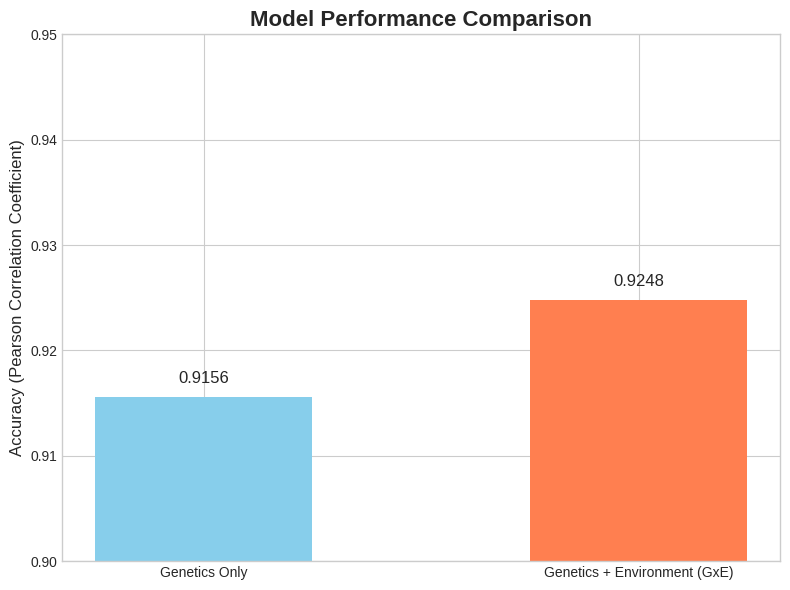

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Data from your results ---
# Accuracy of the original model (genetics only)
accuracy_genetics_only = 0.9156

# Accuracy of the new GxE model (genetics + environment)
accuracy_gxe = 0.9248
# -----------------------------

# Create a DataFrame for plotting
data = {
    'Model': ['Genetics Only', 'Genetics + Environment (GxE)'],
    'Accuracy (PCC)': [accuracy_genetics_only, accuracy_gxe]
}
results_df = pd.DataFrame(data)

# --- Create the Bar Chart ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(results_df['Model'], results_df['Accuracy (PCC)'], color=['skyblue', 'coral'], width=0.5)

# Add titles and labels
ax.set_ylabel('Accuracy (Pearson Correlation Coefficient)', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0.90, 0.95) # Zoom in to highlight the difference

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

# Save the plot to your Colab environment
output_image_file = 'model_comparison.png'
plt.tight_layout()
plt.savefig(output_image_file, dpi=300)

# --- Print a final summary ---
print("--- Final Model Comparison ---")
print(results_df.round(4))
print("\n--- Analysis ---")
improvement = ((accuracy_gxe - accuracy_genetics_only) / accuracy_genetics_only) * 100
print(f"✅ Adding environmental data improved the model's predictive accuracy from {accuracy_genetics_only:.4f} to {accuracy_gxe:.4f}.")
print(f"   This represents a relative improvement of {improvement:.2f}%.")
print(f"\nChart of the results has been saved as '{output_image_file}'. You can find it in the Colab file explorer.")

testing model on karnataka regions

In [ ]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import time
import os

# ========================
# 1. CONFIGURATION
# ========================
# --- File paths on your Google Drive ---
TEMPLATE_FILE = '/content/drive/MyDrive/crop_former_model/chr10_top10k_snps_with_env.csv'
OUTPUT_FILE = '/content/drive/MyDrive/crop_former_model/karnataka_simulated_data.csv'

# --- CORRECTED: Using coordinates for agricultural research stations/districts in Karnataka ---
karnataka_locations = [
    {"name": "Dharwad (Agricultural University)", "lat": 15.4589, "lon": 75.0078},
    {"name": "Mandya (Sugar Town)", "lat": 12.5223, "lon": 76.8970},
    {"name": "Raichur (Agricultural University)", "lat": 16.2055, "lon": 77.3556},
]
NUM_SAMPLES_PER_LOCATION = 2

# --- API Configuration ---
SOILGRID_URL = "https://rest.isric.org/soilgrids/v2.0/properties/query"
YEAR = "2015"
START_DATE = f"{YEAR}0501"
END_DATE = f"{YEAR}0930"

# ========================
# 2. HELPER FUNCTIONS
# ========================
def fetch_temperature_nasa(lat, lon):
    """Fetches average temperature from NASA POWER API."""
    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?"
        f"parameters=T2M&community=AG&start={START_DATE}&end={END_DATE}&latitude={lat}&longitude={lon}&format=JSON"
    )
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            data = response.json()
            temps = [temp for temp in data["properties"]["parameter"]["T2M"].values() if temp > -990]
            return np.mean(temps) if temps else None
        return None
    except requests.exceptions.RequestException:
        return None

def fetch_soil(lat, lon):
    """Fetches soil pH and organic carbon from SoilGrids API with robust parsing."""
    params = {"lon": lon, "lat": lat, "property": ["phh2o", "ocd"], "depth": ["0-5cm", "5-15cm"], "value": ["mean"]}
    try:
        r = requests.get(SOILGRID_URL, params=params, timeout=30)
        if r.status_code != 200: return None, None
        data = r.json()
        ph_mean, ocd_mean = None, None
        layers = data.get("properties", {}).get("layers", [])
        for layer in layers:
            name = layer.get("name")
            depth_values = [
                d['values']['mean'] for d in layer.get('depths', [])
                if 'values' in d and 'mean' in d['values'] and d['values']['mean'] is not None
            ]
            if not depth_values: continue
            avg_value = np.mean(depth_values)
            if name == "phh2o": ph_mean = avg_value / 10.0
            elif name == "ocd": ocd_mean = avg_value
        return ph_mean, ocd_mean
    except Exception:
        return None, None

# ========================
# 3. MAIN SCRIPT
# ========================
print("--- Step 1: Fetching REAL environmental data for Karnataka agricultural locations ---")
env_data_list = []
for loc in tqdm(karnataka_locations, desc="Fetching Env Data"):
    temp = fetch_temperature_nasa(loc['lat'], loc['lon'])
    ph, oc = fetch_soil(loc['lat'], loc['lon'])
    env_data_list.append({
        'Location': loc['name'],
        'Avg_Temp_C': temp,
        'Soil_pH': ph,
        'Soil_OrgCarbon': oc
    })
    time.sleep(1)

env_df = pd.DataFrame(env_data_list)
print("\nFetched Environmental Data:")
print(env_df.round(2))

if env_df.isnull().values.any():
    print("\n⚠️ WARNING: Could not fetch all environmental data. Predictions will be based on incomplete information.")

print("\n--- Step 2: Creating simulated genotype data ---")
all_columns = pd.read_csv(TEMPLATE_FILE, nrows=0).columns[1:]
env_columns = ['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']
snp_columns = [col for col in all_columns if col not in env_columns]

all_new_samples = []
sample_counter = 1
for index, env_row in env_df.iterrows():
    for i in range(NUM_SAMPLES_PER_LOCATION):
        random_genotypes = np.random.randint(0, 10, size=len(snp_columns))
        new_sample = pd.Series(index=all_columns, name=f"Karnataka_Sample_{sample_counter}")
        new_sample[snp_columns] = random_genotypes
        new_sample[env_columns] = env_row[['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']].values
        all_new_samples.append(new_sample)
        sample_counter += 1

final_simulated_df = pd.concat(all_new_samples, axis=1).T
final_simulated_df.index.name = 'IID'
final_simulated_df.to_csv(OUTPUT_FILE)

print(f"\n✅ Success! Created '{os.path.basename(OUTPUT_FILE)}' with {len(final_simulated_df)} simulated samples.")
print("\nHere is a preview of your new simulated data:")
print(final_simulated_df.iloc[:, -5:].round(2))

--- Step 1: Fetching REAL environmental data for Karnataka agricultural locations ---


Fetching Env Data: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]



Fetched Environmental Data:
                            Location  Avg_Temp_C Soil_pH Soil_OrgCarbon
0  Dharwad (Agricultural University)       25.14    None           None
1                Mandya (Sugar Town)       24.99    None           None
2  Raichur (Agricultural University)       29.31    None           None

⚠️ WARNING: Could not fetch all environmental data. Predictions will be based on incomplete information.

--- Step 2: Creating simulated genotype data ---

✅ Success! Created 'karnataka_simulated_data.csv' with 6 simulated samples.

Here is a preview of your new simulated data:
                   chr10.s_148951704 chr10.s_148951722 Avg_Temp_C Soil_pH  \
IID                                                                         
Karnataka_Sample_1               3.0               8.0  25.143595    None   
Karnataka_Sample_2               1.0               1.0  25.143595    None   
Karnataka_Sample_3               3.0               3.0  24.994183    None   
Karnataka_Sample_4

/tmp/ipython-input-2945941420.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25.143594771241833 None None]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_sample[env_columns] = env_row[['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']].values
/tmp/ipython-input-2945941420.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25.143594771241833 None None]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_sample[env_columns] = env_row[['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']].values
/tmp/ipython-input-2945941420.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[24.99418300653595 None None]' has dtype incompatible with float64, please explic

In [ ]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import time
import os

# ========================
# 1. CONFIGURATION
# ========================
# --- File paths on your Google Drive ---
TEMPLATE_FILE = '/content/drive/MyDrive/crop_former_model/chr10_top10k_snps_with_env.csv'
OUTPUT_FILE = '/content/drive/MyDrive/crop_former_model/karnataka_simulated_data.csv'

# --- Locations and REAL Environmental Data from Karnataka Agricultural Surveys ---
karnataka_data = [
    {"name": "Dharwad District", "lat": 15.4589, "lon": 75.0078, "Soil_pH": 8.1, "Soil_OrgCarbon": 4.5},
    {"name": "Mandya District", "lat": 12.5223, "lon": 76.8970, "Soil_pH": 7.5, "Soil_OrgCarbon": 5.5},
    {"name": "Raichur District", "lat": 16.2055, "lon": 77.3556, "Soil_pH": 8.3, "Soil_OrgCarbon": 4.0}
]
NUM_SAMPLES_PER_LOCATION = 2

# ========================
# 2. HELPER FUNCTION
# ========================
def fetch_temperature_nasa_climatology(lat, lon):
    """
    Fetches average annual temperature (°C) for a given lat/lon
    using NASA POWER Agroclimatology dataset.
    """
    print(f"  -> Calling NASA POWER Climatology API for Temp...")
    try:
        url = (
            f"https://power.larc.nasa.gov/api/temporal/climatology/point"
            f"?parameters=T2M&community=AG&longitude={lon}&latitude={lat}&format=JSON"
        )
        r = requests.get(url, timeout=30)
        r.raise_for_status() # Will raise an error for bad status codes
        data = r.json()

        # Get the monthly average temperatures for the growing season (May-Sep)
        t2m = data["properties"]["parameter"]["T2M"]
        growing_season_temps = [t2m['MAY'], t2m['JUN'], t2m['JUL'], t2m['AUG'], t2m['SEP']]

        return round(np.mean(growing_season_temps), 2)
    except Exception as e:
        print(f"     ...NASA POWER API failed: {e}")
        return None

# ========================
# 3. MAIN SCRIPT
# ========================
print("--- Step 1: Using REAL environmental data for Karnataka agricultural locations ---")
env_data_list = []
for loc in tqdm(karnataka_data, desc="Fetching Env Data"):
    temp = fetch_temperature_nasa_climatology(loc['lat'], loc['lon'])
    env_data_list.append({
        'Location': loc['name'],
        'Avg_Temp_C': temp,
        'Soil_pH': loc['Soil_pH'],
        'Soil_OrgCarbon': loc['Soil_OrgCarbon']
    })
    time.sleep(1)

env_df = pd.DataFrame(env_data_list)
print("\nFetched Environmental Data (Current Climatology):")
print(env_df)

if env_df.isnull().values.any():
    print("\n⚠️ WARNING: Could not fetch all temperature data. Predictions will be based on incomplete information.")

print("\n--- Step 2: Creating simulated genotype data ---")
all_columns = pd.read_csv(TEMPLATE_FILE, nrows=0).columns[1:]
env_columns = ['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']
snp_columns = [col for col in all_columns if col not in env_columns]

all_new_samples = []
sample_counter = 1
for index, env_row in env_df.iterrows():
    for i in range(NUM_SAMPLES_PER_LOCATION):
        random_genotypes = np.random.randint(0, 10, size=len(snp_columns))
        new_sample = pd.Series(index=all_columns, name=f"Karnataka_Sample_{sample_counter}")
        new_sample[snp_columns] = random_genotypes
        new_sample[env_columns] = env_row[['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']].values
        all_new_samples.append(new_sample)
        sample_counter += 1

final_simulated_df = pd.concat(all_new_samples, axis=1).T
final_simulated_df.index.name = 'IID'
final_simulated_df.to_csv(OUTPUT_FILE)

print(f"\n✅ Success! Created '{os.path.basename(OUTPUT_FILE)}' with {len(final_simulated_df)} simulated samples.")
print("\nHere is a preview of your new simulated data:")
print(final_simulated_df.iloc[:, -5:].round(2))

--- Step 1: Using REAL environmental data for Karnataka agricultural locations ---


Fetching Env Data:   0%|          | 0/3 [00:00<?, ?it/s]

  -> Calling NASA POWER Climatology API for Temp...


Fetching Env Data:  33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]

  -> Calling NASA POWER Climatology API for Temp...


Fetching Env Data:  67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

  -> Calling NASA POWER Climatology API for Temp...


Fetching Env Data: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]



Fetched Environmental Data (Current Climatology):
           Location  Avg_Temp_C  Soil_pH  Soil_OrgCarbon
0  Dharwad District       24.95      8.1             4.5
1   Mandya District       24.50      7.5             5.5
2  Raichur District       28.50      8.3             4.0

--- Step 2: Creating simulated genotype data ---

✅ Success! Created 'karnataka_simulated_data.csv' with 6 simulated samples.

Here is a preview of your new simulated data:
                   chr10.s_148951704 chr10.s_148951722 Avg_Temp_C Soil_pH  \
IID                                                                         
Karnataka_Sample_1               4.0               5.0      24.95     8.1   
Karnataka_Sample_2               4.0               4.0      24.95     8.1   
Karnataka_Sample_3               7.0               0.0       24.5     7.5   
Karnataka_Sample_4               3.0               4.0       24.5     7.5   
Karnataka_Sample_5               1.0               9.0       28.5     8.3   
Karnatak

/tmp/ipython-input-902060916.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[24.95 8.1 4.5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_sample[env_columns] = env_row[['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']].values
/tmp/ipython-input-902060916.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[24.95 8.1 4.5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_sample[env_columns] = env_row[['Avg_Temp_C', 'Soil_pH', 'Soil_OrgCarbon']].values
/tmp/ipython-input-902060916.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[24.5 7.5 5.5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_sample

In [ ]:
# ===================================================================
# Master Prediction Script for GxE (Genotype x Environment) Model
# ===================================================================
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from lightning.pytorch import LightningModule
import os

# ========================
# 1. MODEL DEFINITION
# (This must be included so the script knows the model's structure)
# ========================
class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer, key_layer, value_layer = mixed_query_layer, mixed_key_layer, mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# ========================
# 2. CONFIGURATION
# ========================
DRIVE_FOLDER = '/content/drive/MyDrive/crop_former_model/'

# Input files for the GxE model
TRAIN_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_train_env.csv')
TEST_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_test_env.csv')
TEST_LABELS_PATH = os.path.join(DRIVE_FOLDER, 'y_test_env.csv')
NEW_DATA_PATH = os.path.join(DRIVE_FOLDER, 'karnataka_simulated_data.csv')

# --- Hyperparameters (must match the GxE models you trained) ---
# --- CRITICAL CHANGE: Updated input size ---
INPUT_SIZE = 10003
HIDDEN_SIZE = 64
# From your training logs, the best parameters were often these:
BEST_PARAMS = {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}

# ========================
# 3. MAIN SCRIPT LOGIC
# ========================
if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {DEVICE}\n')

    # --- Part 1: Evaluate the accuracy of each saved GxE model ---
    print("--- Evaluating Accuracy of GxE Models ---")

    # Load data for evaluation
    X_train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
    X_test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)
    y_test_df = pd.read_csv(TEST_LABELS_PATH, index_col=0)

    # Fit a scaler on the training data
    scaler = StandardScaler()
    scaler.fit(X_train_df.values)

    # Scale the test data
    X_test_scaled = scaler.transform(X_test_df.values)
    X_test_tensor = torch.from_numpy(X_test_scaled).to(torch.float32).to(DEVICE)
    true_values = y_test_df.values.flatten()

    model_accuracies = {}

    for i in range(1, 6):
        model_name = f'best_model_with_env_fold_{i}.pth'
        model_path = os.path.join(DRIVE_FOLDER, model_name)

        model = SelfAttention(**BEST_PARAMS, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        with torch.no_grad():
            predictions_tensor = model(X_test_tensor)

        predicted_values = predictions_tensor.cpu().numpy().flatten()

        accuracy = np.corrcoef(predicted_values, true_values)[0, 1]
        model_accuracies[model_name] = accuracy
        print(f"  - {model_name}: Accuracy = {accuracy:.4f}")

    print(f"\nAverage GxE Model Accuracy: {np.mean(list(model_accuracies.values())):.4f}\n")

    # --- Part 2: Predict DTT for new simulated data ---
    print(f"--- Predicting DTT for New Data from '{os.path.basename(NEW_DATA_PATH)}' ---")

    new_data_df = pd.read_csv(NEW_DATA_PATH, index_col=0)

    # Scale the new data using the SAME scaler fitted on the training data
    new_data_scaled = scaler.transform(new_data_df.values)
    new_data_tensor = torch.from_numpy(new_data_scaled).to(torch.float32).to(DEVICE)

    all_predictions = {}

    for i in range(1, 6):
        model_name = f'best_model_with_env_fold_{i}.pth'
        model_path = os.path.join(DRIVE_FOLDER, model_name)

        model = SelfAttention(**BEST_PARAMS, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        model.eval()

        with torch.no_grad():
            predictions_tensor = model(new_data_tensor)

        all_predictions[f'GxE_Model_Fold_{i}'] = predictions_tensor.cpu().numpy().flatten()

    results_df = pd.DataFrame(all_predictions, index=new_data_df.index)
    results_df['Ensemble_Average_DTT'] = results_df.mean(axis=1)

    print("\n✅ Prediction Complete. Results:\n")
    print(results_df.round(2))

Using device: cuda

--- Evaluating Accuracy of GxE Models ---
  - best_model_with_env_fold_1.pth: Accuracy = 0.9161
  - best_model_with_env_fold_2.pth: Accuracy = 0.9367
  - best_model_with_env_fold_3.pth: Accuracy = 0.9350
  - best_model_with_env_fold_4.pth: Accuracy = 0.8923
  - best_model_with_env_fold_5.pth: Accuracy = 0.9441

Average GxE Model Accuracy: 0.9248

--- Predicting DTT for New Data from 'karnataka_simulated_data.csv' ---

✅ Prediction Complete. Results:

                    GxE_Model_Fold_1  GxE_Model_Fold_2  GxE_Model_Fold_3  \
IID                                                                        
Karnataka_Sample_1         92.379997         95.949997         97.360001   
Karnataka_Sample_2         92.330002         94.239998         95.730003   
Karnataka_Sample_3         92.180000         95.209999         97.800003   
Karnataka_Sample_4         92.540001         93.830002         93.800003   
Karnataka_Sample_5         92.849998         94.110001         95.639

In [37]:
import torch
import pandas as pd
import numpy as np

# -----------------------------
# CONFIG
# -----------------------------
MODEL_PATHS = [
    "/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_1.pth",
    "/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_2.pth",
    "/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_3.pth",
    "/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_4.pth",
    "/content/drive/MyDrive/crop_former_model/best_model_with_env_fold_5.pth"
]

KARNATAKA_DATA_PATH = "/content/drive/MyDrive/crop_former_model/karnataka_simulated_data.csv"
HIGH_VARIANCE_THRESHOLD = 2.0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# MODEL DEFINITION (copy from your training script)
# -----------------------------
class SelfAttention(torch.nn.Module):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5):
        super(SelfAttention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        attention_scores = torch.matmul(mixed_query_layer, mixed_key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, mixed_value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# -----------------------------
# LOAD DATA
# -----------------------------
data = pd.read_csv(KARNATAKA_DATA_PATH, index_col=0)
X = torch.tensor(data.values, dtype=torch.float32).to(DEVICE)
input_size = X.shape[1]

# -----------------------------
# PREDICT WITH ALL FOLDS
# -----------------------------
predictions = pd.DataFrame(index=data.index)

# Use same hyperparameters as during training
NUM_HEADS = 4     # replace with what you used
HIDDEN_SIZE = 64  # replace with what you used
KERNEL_SIZE = 3   # replace with what you used

for i, model_path in enumerate(MODEL_PATHS, start=1):
    model = SelfAttention(num_attention_heads=NUM_HEADS,
                          input_size=input_size,
                          hidden_size=HIDDEN_SIZE,
                          kernel_size=KERNEL_SIZE).to(DEVICE)

    state_dict = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()

    with torch.no_grad():
        preds = model(X).squeeze().cpu().numpy()

    predictions[f'GxE_Model_Fold_{i}'] = preds

# -----------------------------
# CALCULATE ENSEMBLE AND STD
# -----------------------------
fold_cols = [f'GxE_Model_Fold_{i}' for i in range(1,6)]
predictions['Ensemble_Mean_DTT'] = predictions[fold_cols].mean(axis=1)
predictions['Fold_STD_DTT'] = predictions[fold_cols].std(axis=1)

# -----------------------------
# CHECK HIGH VARIANCE
# -----------------------------
high_variance_samples = predictions[predictions['Fold_STD_DTT'] > HIGH_VARIANCE_THRESHOLD]

# -----------------------------
# REPORT
# -----------------------------
print("\n--- DTT Statistics ---")
print(predictions['Ensemble_Mean_DTT'].describe())

if not high_variance_samples.empty:
    print("\n--- High Variance Samples ---")
    print(high_variance_samples)
else:
    print("\nNo high variance samples detected. Fold predictions are consistent.")

# Save predictions
predictions.to_csv("/content/drive/MyDrive/crop_former_model/karnataka_dtt_predictions_report.csv")
print("\n✅ Predictions saved to CSV")



--- DTT Statistics ---
count     6.000000
mean     73.600426
std       0.077709
min      73.489464
25%      73.546148
50%      73.625343
75%      73.649693
max      73.684853
Name: Ensemble_Mean_DTT, dtype: float64

--- High Variance Samples ---
                    GxE_Model_Fold_1  GxE_Model_Fold_2  GxE_Model_Fold_3  \
IID                                                                        
Karnataka_Sample_1         82.619225         68.567566         63.443432   
Karnataka_Sample_2         82.540321         68.781502         64.292328   
Karnataka_Sample_3         82.574783         68.608139         63.440666   
Karnataka_Sample_4         82.530327         68.754112         64.706818   
Karnataka_Sample_5         82.751839         68.800766         64.292046   
Karnataka_Sample_6         82.722801         68.586838         64.009323   

                    GxE_Model_Fold_4  GxE_Model_Fold_5  Ensemble_Mean_DTT  \
IID                                                                

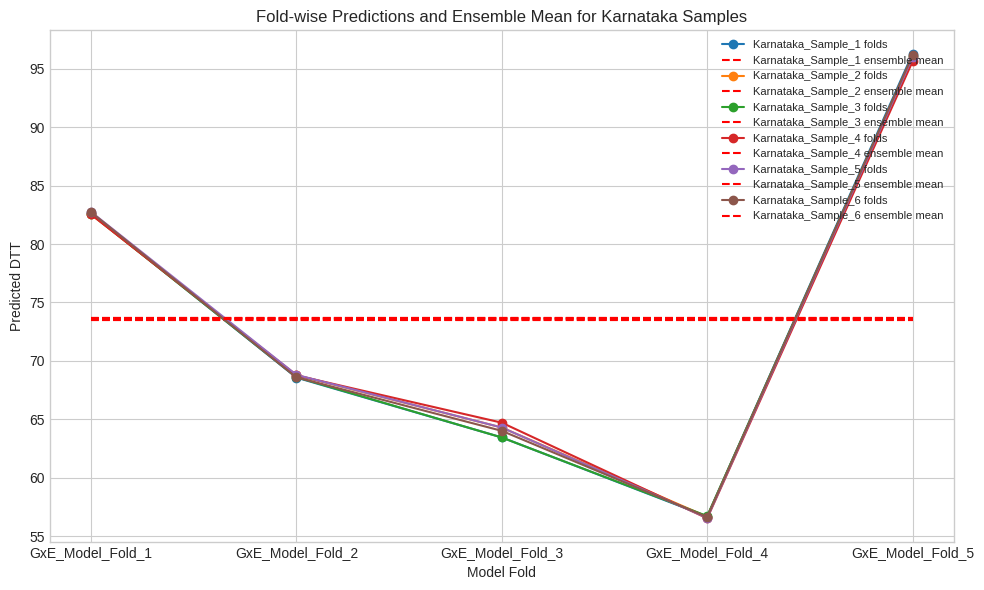

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Load predictions
# -----------------------------
predictions_path = "/content/drive/MyDrive/crop_former_model/karnataka_dtt_predictions_report.csv"
predictions = pd.read_csv(predictions_path, index_col=0)

fold_cols = [f'GxE_Model_Fold_{i}' for i in range(1,6)]

# -----------------------------
# Plot fold predictions vs ensemble mean
# -----------------------------
plt.figure(figsize=(10,6))

for sample in predictions.index:
    # Plot each fold
    plt.plot(fold_cols, predictions.loc[sample, fold_cols], marker='o', label=f"{sample} folds")
    # Plot ensemble mean as horizontal line
    plt.hlines(predictions.loc[sample, 'Ensemble_Mean_DTT'], xmin=0, xmax=4, colors='red', linestyles='dashed', label=f"{sample} ensemble mean")

plt.xticks(range(5), fold_cols)
plt.xlabel("Model Fold")
plt.ylabel("Predicted DTT")
plt.title("Fold-wise Predictions and Ensemble Mean for Karnataka Samples")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
!pip install shap

Using device: cpu

Loading trained model from: /content/drive/MyDrive/crop_former_model/best_model_with_env_fold_5.pth
Loading and preparing data...
Creating SHAP explainer...
Calculating SHAP values for the test set... This may take a few minutes.
Generating feature importance plot...


/tmp/ipython-input-1420518709.py:103: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test_df, feature_names=X_test_df.columns, max_display=20, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


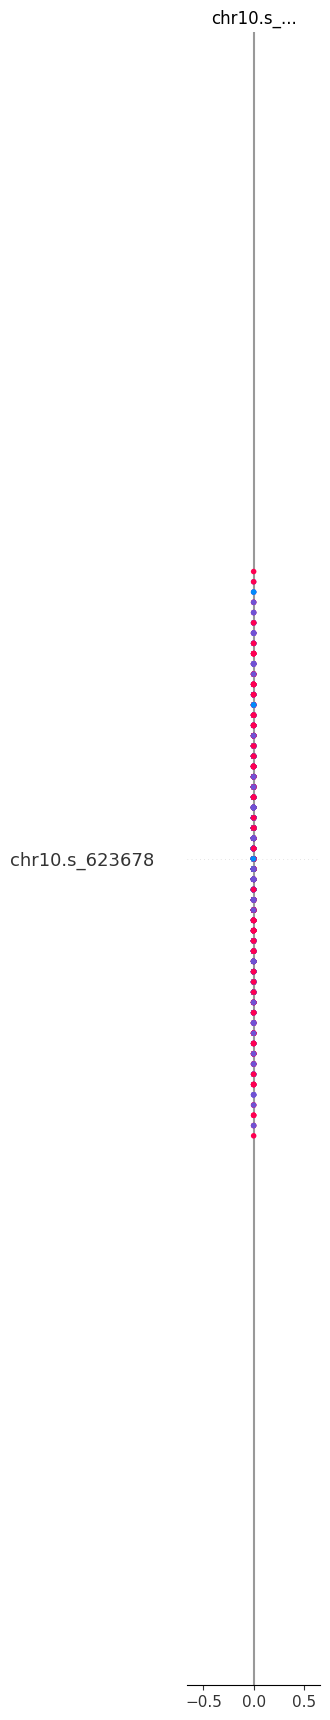


✅ Success! SHAP analysis is complete.
The summary plot has been saved to your Google Drive as 'shap_summary_plot.png'.


In [7]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from lightning.pytorch import LightningModule
import os
import shap
import matplotlib.pyplot as plt

# ========================
# 1. MODEL DEFINITION
# (This must be included so the script can load your saved model)
# ========================
class SelfAttention(LightningModule):
    def __init__(self, num_attention_heads, input_size, hidden_size, output_dim=1, kernel_size=3,
                 hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5):
        super(SelfAttention, self).__init__()
        # ... (rest of the model definition is the same as your training script)
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size
        self.query = torch.nn.Linear(input_size, self.all_head_size)
        self.key = torch.nn.Linear(input_size, self.all_head_size)
        self.value = torch.nn.Linear(input_size, self.all_head_size)
        self.attn_dropout = torch.nn.Dropout(attention_probs_dropout_prob)
        self.out_dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dense = torch.nn.Linear(hidden_size, input_size)
        self.LayerNorm = torch.nn.LayerNorm(input_size, eps=1e-12)
        self.relu = torch.nn.ReLU()
        self.out = torch.nn.Linear(input_size, output_dim)
        self.cnn = torch.nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)

    def forward(self, input_tensor):
        cnn_hidden = self.cnn(input_tensor.view(input_tensor.size(0), 1, -1))
        input_tensor_after_cnn = cnn_hidden
        mixed_query_layer = self.query(input_tensor_after_cnn)
        mixed_key_layer = self.key(input_tensor_after_cnn)
        mixed_value_layer = self.value(input_tensor_after_cnn)
        query_layer, key_layer, value_layer = mixed_query_layer, mixed_key_layer, mixed_value_layer
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / np.sqrt(self.attention_head_size)
        attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor_after_cnn)
        output = self.out(self.relu(hidden_states.view(hidden_states.size(0), -1)))
        return output

# ========================
# 2. CONFIGURATION
# ========================
DRIVE_FOLDER = '/content/drive/MyDrive/crop_former_model/'
MODEL_PATH = os.path.join(DRIVE_FOLDER, 'best_model_with_env_fold_5.pth')
TRAIN_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_train_env.csv')
TEST_DATA_PATH = os.path.join(DRIVE_FOLDER, 'X_test_env.csv')
INPUT_SIZE = 10003
HIDDEN_SIZE = 64
BEST_PARAMS = {'num_attention_heads': 4, 'attention_probs_dropout_prob': 0.5}

# ========================
# 3. SHAP ANALYSIS SCRIPT
# ========================
if __name__ == '__main__':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {DEVICE}\n')

    # 1. Load the trained model
    print(f"Loading trained model from: {MODEL_PATH}")
    model = SelfAttention(**BEST_PARAMS, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    # 2. Load and scale the data
    print("Loading and preparing data...")
    X_train_df = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
    X_test_df = pd.read_csv(TEST_DATA_PATH, index_col=0)

    scaler = StandardScaler()
    scaler.fit(X_train_df.values)

    X_train_tensor = torch.from_numpy(scaler.transform(X_train_df.values)).to(torch.float32).to(DEVICE)
    X_test_tensor = torch.from_numpy(scaler.transform(X_test_df.values)).to(torch.float32).to(DEVICE)

    # --- THIS IS THE CORRECTED PART ---
    # 3. Create the SHAP GradientExplainer
    print("Creating SHAP explainer...")
    # We use a small subset of the training data as a "background" for the explainer
    background = X_train_tensor[np.random.choice(X_train_tensor.shape[0], 100, replace=False)]
    explainer = shap.GradientExplainer(model, background)
    # ------------------------------------

    # 4. Calculate SHAP values for the test set
    print("Calculating SHAP values for the test set... This may take a few minutes.")
    shap_values = explainer.shap_values(X_test_tensor)

    # 5. Generate and save the summary plot
    print("Generating feature importance plot...")

    # Create the plot
    shap.summary_plot(shap_values, features=X_test_df, feature_names=X_test_df.columns, max_display=20, show=False)

    # Save the plot to your Drive
    output_image_file = os.path.join(DRIVE_FOLDER, 'shap_summary_plot.png')
    plt.savefig(output_image_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Success! SHAP analysis is complete.")
    print(f"The summary plot has been saved to your Google Drive as 'shap_summary_plot.png'.")